In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Simulace $ \sin(\pi x) $ pomocí neuronové sítě

V této úloze se pokusíme simulovat funkci $ \sin(\pi x) $ na intervalu $ \langle 0,1\rangle $ pomocí jednoduché neuronové sítě s jednou skrytou vrstvou. Neuronová síť je učena pomocí uměle vygenerovaných dat s přidaným šumem.

Text(0, 0.5, 'sin(πx)')

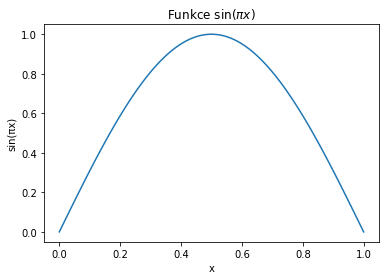

In [ ]:
# Vzkreslení aproximované funkce
x = np.linspace(0, 1, 100)
y = np.sin(np.pi * x)

plt.plot(x, y)
plt.title('Funkce $ \sin(\pi x) $')
plt.xlabel('x')
plt.ylabel('sin(πx)')

Neuronová síť má následující vlastnosti:
- jeden vstupní neuron
- jedna skrytá vrstva se 2 neurony používajícími aktivační funkci Tanh
- jeden výstupní neuron

Proces definice, učení a vyhodnocování výkonnosti neuronové sítě je rozdělen do několika kroků:

**Krok 1:** Definujeme architekturu neuronové sítě, včetně jedné skryté vrstvy se 2 neurony a aktivační funkce $tanh()$.

**Krok 2:** Vygenerujeme tréninková data z funkce $ \sin(\pi x) $ s přidaným šumem a testovací data (bez šumu).

**Krok 3:** Tréninková data převedeme do `DataLoader` pro učení v dávkách. Inicializujeme neuronovou síť, definujeme ztrátovou funkci (MSE) a nastavíme optimalizátor Adam s learning rate $10^{-2}$.

**Krok 4:** Spustíme smyčku pro učení na 500 epoch. Aproximaci funkce $ \sin(\pi x) $ uložíme pro zvolené epochy pro pozdější vykreslení. Uložíme také hodnotu ztráty, relativní chyby a $R^2$ skóre v každé epoše.

**Krok 5:** Vyhodnotíme model na testovacích datech a vypočteme relativní chybu a $R^2$ skóre mezi předpověďmi sítě a skutečnými hodnotami funkce.

**Krok 6:** Vykreslíme modelovanou funkci $ \sin(\pi x) $ a porovnáme ji s aproximacemi provedenými neuronovou sítí po různých epochách učení. Dále vytvoříme graf, který zobrazuje hodnoty ztrátové funkce v závislosti na počtu epoch. Vykraslíme také hodnoty relativní chyby a R2 skóre.

In [3]:
# Krok 1: Definujeme model neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Síť s jedním vstupem, jedním výstupem a jednou skrytou vrstvou
        self.fc1 = nn.Linear(1, 2) # Vstupní vrstva (vstup: 1, skryté: 2)
        self.tanh1 = nn.Tanh() # Aktivační funkce
        self.fc2 = nn.Linear(2, 1) # Výstupní vrstva (skryté: 2, výstup: 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        return x

In [4]:
# Krok 2.1: Vygenerování trénovacího datasetu se šumem
x_train = np.linspace(0, 1, 300).reshape(-1, 1) # Trénovací data rovnoměrně rozložena v intervalu [0, 1]
y_train = np.sin(np.pi * x_train) # Výstupy modelované funkce

# Zašumění dat (šum se střední hodnotou 0 a směrodatnou odchylkou 0,05)
noise = np.random.normal(0, 0.05, size=y_train.shape)
y_train_noisy = y_train + noise
    
# Převod dat na PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_noisy, dtype=torch.float32)

In [5]:
# Krok 2.2: Vygenerování testovacího datasetu
x_test = np.random.rand(100, 1) # Testovací data náhodně rozložena v intervalu [0, 1]
x_test_sorted = np.sort(x_test, axis=0) # Uspořádání testovacích dat
y_test = np.sin(np.pi * x_test_sorted) # Opravdové hodnoty modeloavné funkce

# Převod dat na PyTorch tensors
x_test_tensor = torch.tensor(x_test_sorted, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [6]:
# Krok 3.1: Vytvoření DataLoader pro učení neuronové sítě v dávkách
dataset = TensorDataset(x_train_tensor, y_train_tensor)
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Krok 3.2: Inicializace modelu, ztrátové funkce a optimalizátoru
model = MyModel()
criterion = nn.MSELoss()  # Střední kvadratická chyba (MSE)
optimizer = optim.Adam(model.parameters(), lr=1e-2) # Optimalizátor

In [ ]:
# Krok 4: Smyčka pro učení neuronové sítě
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs_to_save = [1, 10, 30, 60, 150, 500]  # Epochy, které chceme vykreslit
approximations = [] # Seznam pro ukládání predikcí hodnot v daných epochách
relative_error_values = [] # Seznam pro ukládání relativních chyb predikce modelu v každé epoše
r2_values = [] # Seznam pro ukládání R^2 skóre predikce modelu v každé epoše
num_epochs = 500 # Počet epoch
# Smyčka pro učení neuronové sítě
for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in dataloader:
 
        outputs = model(inputs) # Forward pass
 
        loss = criterion(outputs, labels) # Výpočet ztráty

        optimizer.zero_grad() # Vynulování gradientů parametrů
 
        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
 
        running_loss += loss.item() * inputs.size(0)

    # Výpočet a uložení průměrné ztráty pro tuto epochu
    epoch_loss = running_loss / len(dataset)
    loss_values.append(epoch_loss)

    # Testování modelu pro následné vykreslení aproximací a chyb NN
    with torch.no_grad():
        model.eval()
        x_pred_test = model(x_test_tensor)
        
        # Relativní chyba
        numerator = torch.norm(x_pred_test - y_test)
        denominator = torch.norm(y_test_tensor)
        relative_error = (numerator / denominator).item()
        relative_error_values.append(relative_error)
        
        # R2 skóre
        y_test_mean = torch.mean(y_test_tensor)
        ss_res = torch.sum((x_pred_test - y_test_tensor)**2)
        ss_tot = torch.sum((y_test_tensor - y_test_mean)**2)
        r2_score = 1 - (ss_res / ss_tot).item()
        r2_values.append(r2_score)

    # Uložení predikce pro dané epochy
    if (epoch + 1) in epochs_to_save:
        approximations.append(x_pred_test.detach().numpy())
 
    # Výpis průměrné ztráty pro tuto epochu
    print(f'Epocha [{epoch+1}/{num_epochs}], Ztráta: {running_loss/len(dataset):.4f}')

# Vyhledání nejlepší epochy dle relativní chyby
min_value = min(relative_error_values)
min_index = relative_error_values.index(min_value)
print(f'Nejlepší epocha [{min_index+1}/{num_epochs}], Relativní chyba: {min_value:.4f}')

Epocha [1/500], Ztráta: 0.3635
Epocha [2/500], Ztráta: 0.0987
Epocha [3/500], Ztráta: 0.0988
Epocha [4/500], Ztráta: 0.0988
Epocha [5/500], Ztráta: 0.0986
Epocha [6/500], Ztráta: 0.0988
Epocha [7/500], Ztráta: 0.0991
Epocha [8/500], Ztráta: 0.0981
Epocha [9/500], Ztráta: 0.0990
Epocha [10/500], Ztráta: 0.0972
Epocha [11/500], Ztráta: 0.0977
Epocha [12/500], Ztráta: 0.0974
Epocha [13/500], Ztráta: 0.0975
Epocha [14/500], Ztráta: 0.0948
Epocha [15/500], Ztráta: 0.0932
Epocha [16/500], Ztráta: 0.0909
Epocha [17/500], Ztráta: 0.0875
Epocha [18/500], Ztráta: 0.0846
Epocha [19/500], Ztráta: 0.0812
Epocha [20/500], Ztráta: 0.0737
Epocha [21/500], Ztráta: 0.0695
Epocha [22/500], Ztráta: 0.0617
Epocha [23/500], Ztráta: 0.0543
Epocha [24/500], Ztráta: 0.0453
Epocha [25/500], Ztráta: 0.0366
Epocha [26/500], Ztráta: 0.0295
Epocha [27/500], Ztráta: 0.0234
Epocha [28/500], Ztráta: 0.0178
Epocha [29/500], Ztráta: 0.0140
Epocha [30/500], Ztráta: 0.0121
Epocha [31/500], Ztráta: 0.0103
Epocha [32/500], 

In [9]:
# Krok 5: Testování modelu neuronové sítě a výpočet chyby
with torch.no_grad():
    model.eval()
    predicted = model(x_test_tensor) # Hodnoty predikované neuronovou sítí
    true_values = torch.sin(np.pi * x_test_tensor) # Skutečné hodnoty

    test_loss = criterion(predicted, y_test_tensor)
    print(f'Testovací ztráta: {test_loss.item():.4f}')
    
    # Výpočet relativní chyby
    error_norm = torch.norm(predicted - true_values)
    true_norm = torch.norm(true_values)
    relative_error = error_norm / true_norm
    print(f'Relativní chyba: {relative_error.item():.4f}')

    # Výpočet R^2 skóre
    y_test_mean = torch.mean(y_test_tensor)
    ss_res = torch.sum((predicted - y_test_tensor)**2)
    ss_tot = torch.sum((y_test_tensor - y_test_mean)**2)
    r2_score = 1 - (ss_res / ss_tot)
    print(f'R^2 skóre: {r2_score.item():.4f}')

Testovací ztráta: 0.0001
Relativní chyba: 0.0138
R^2 skóre: 0.9991


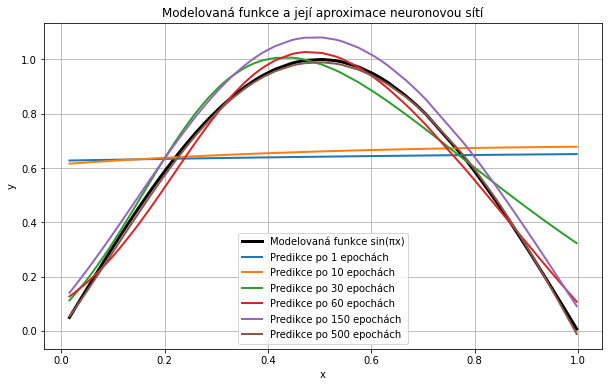

In [10]:
# Krok 6.1: Graf znázorňující zlepšení výkonu neuronové sítě při rostoucím počtu epoch
plt.figure(figsize=(10, 6))
plt.plot(x_test_sorted, y_test, label='Modelovaná funkce sin(πx)', color='black', linewidth=3) # Modelovaná funkce
for i, epoch in enumerate(epochs_to_save):
    plt.plot(x_test_sorted, approximations[i], label=f'Predikce po {epoch} epochách', linewidth=2) # Predikce neuronové sítě
plt.title('Modelovaná funkce a její aproximace neuronovou sítí')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


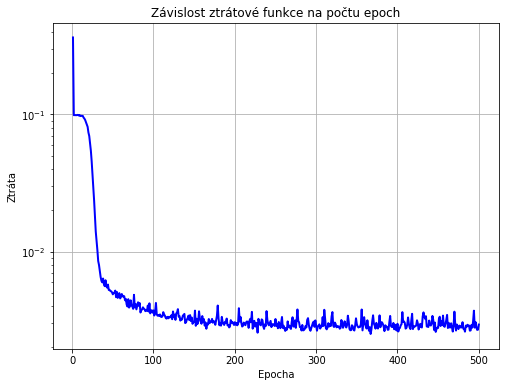

In [11]:
# Krok 6.2: Graf znázorňující závislost ztráty na počtu epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, color='blue', linewidth=2)
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.grid(True)
plt.show()

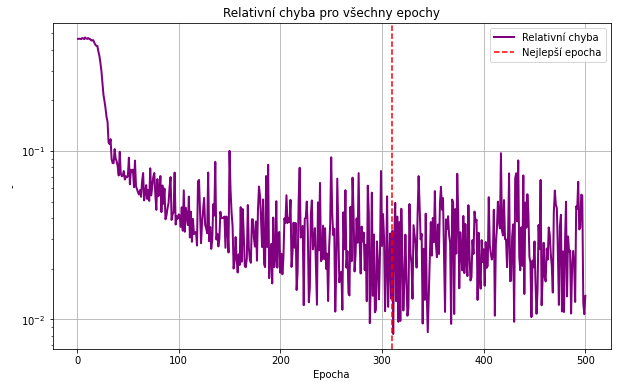

In [12]:
# Krok 6.3: Graf relativní chyby ve všech epochách
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), relative_error_values, color='purple', linewidth=2, label='Relativní chyba')
plt.axvline(min_index, color='r', linestyle='--', label='Nejlepší epocha')
plt.title('Relativní chyba pro všechny epochy')
plt.yscale('log')
plt.xlabel('Epocha')
plt.ylabel('-')
plt.grid(True)
plt.legend()
plt.show()

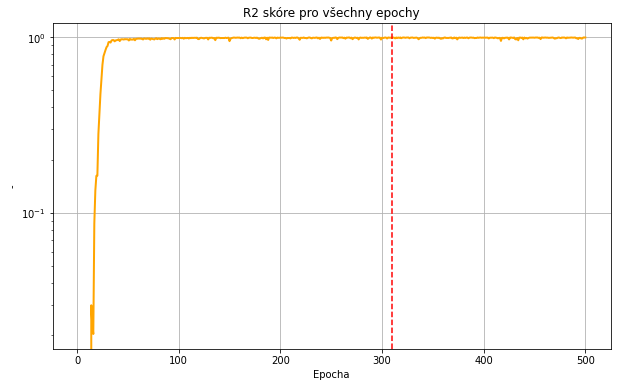

Epocha	R2 skóre
1	-0.0139
10	-0.0152
20	0.1630
60	0.9848
150	0.9526
300	0.9965
310	0.9947
500	0.9991


In [13]:
# Krok 6.4: Vykreslení a výpis R2 skóre
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), r2_values, label='$R2$ skóre', color='orange', linewidth=2)
plt.title('R2 skóre pro všechny epochy')
plt.axvline(min_index, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.xlabel('Epocha')
plt.ylabel('-')
plt.grid(True)
plt.show()

print(f'Epocha\tR2 skóre')
# Výpis hodnoty R2 skóre pro vybrané epochy
for i in  [1, 10, 20, 60, 150, 300, min_index, 500]:
    print(f'{i}\t{r2_values[i-1]:.4f}')